# Diabetes Classification Model

This notebook implements a complete pipeline inspired by the *Final Model Code.ipynb*, 
adapted to the `diabetes_012_health_indicators_BRFSS2015.csv` dataset.
It includes:
- Loading and inspecting the dataset
- Preparation and train/test split
- Model training (Logistic Regression, Random Forest, Gradient Boosting)
- Stratified K-Fold validation
- Multiclass metrics (Accuracy, Balanced Accuracy, F1-macro, ROC-AUC OVR)
- Confusion matrix and ROC curves
- Feature importance interpretation
- Saving the best model for later use

## 1. Imports and Setup

In [31]:
# %% [code] | Imports and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

# General settings
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
DATA_PATH = "./data/diabetes_012_health_indicators_BRFSS2015.csv"
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

## 2. Data loading and inspection

In [32]:
# %% [code] | Data loading and overview
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head())
print("\nDtypes:")
print(df.dtypes.value_counts())
print("\nColumns:", df.columns.tolist())

Dataset shape: (253680, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0



Dtypes:
float64    22
Name: count, dtype: int64

Columns: ['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


## 3. Target and features

In [33]:
# %% [code] | Define target and features
# By default, the target column is 'Diabetes_012' with classes {0: no diabetes, 1: prediabetes, 2: diabetes}
TARGET = "Diabetes_012"
assert TARGET in df.columns, f"Target column '{TARGET}' not found."
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

print("Class distribution (absolute):")
print(y.value_counts().sort_index())
print("\nClass distribution (proportion):")
print(y.value_counts(normalize=True).sort_index())

Class distribution (absolute):
Diabetes_012
0    213703
1      4631
2     35346
Name: count, dtype: int64

Class distribution (proportion):
Diabetes_012
0    0.842412
1    0.018255
2    0.139333
Name: proportion, dtype: float64


## 4. Train/test split

In [34]:
# %% [code] | Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape

((202944, 21), (50736, 21))

## 5. Models

In [35]:
# %% [code] | Model definitions
# Notes:
# - Logistic Regression uses standardization
# - Random Forest and Gradient Boosting do not require scaling
models = {
    "logreg": Pipeline([
        ("scaler", StandardScaler(with_mean=False) if hasattr(X_train, "sparse") else StandardScaler()),
        ("clf", LogisticRegression(max_iter=200, multi_class="ovr", class_weight="balanced", n_jobs=None if "n_jobs" in LogisticRegression().get_params() else None))
    ]),
    "rf": RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2,
        n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced_subsample"
    ),
    "gb": GradientBoostingClassifier(random_state=RANDOM_STATE)
}
list(models.keys())

['logreg', 'rf', 'gb']

## 6. Cross-validation

In [36]:
# %% [code] | Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "roc_auc_ovr": "roc_auc_ovr"
}

cv_results = {}
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_results[name] = {k: (np.mean(v), np.std(v)) for k, v in scores.items() if k.startswith("test_")}

# Show CV results
print("CV results (mean ± std):\n")
for name, metrics in cv_results.items():
    print(f"== {name} ==")
    for metric, (m, s) in metrics.items():
        print(f"  {metric.replace('test_', ''):>18}: {m:.4f} ± {s:.4f}")

/Users/oleitao/Documents/Repos/DataTalks.Club/ml_zoomcamp_datatalks/midterm-project-2025/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/oleitao/Documents/Repos/DataTalks.Club/ml_zoomcamp_datatalks/midterm-project-2025/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/oleitao/Documents/Repos/DataTalks.Club/ml_zoomcamp_datatalks/midterm-project-2025/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed i

CV results (mean ± std):

== logreg ==
            accuracy: 0.6891 ± 0.0025
   balanced_accuracy: 0.5121 ± 0.0037
            f1_macro: 0.4358 ± 0.0018
         roc_auc_ovr: 0.7800 ± 0.0031
== rf ==
            accuracy: 0.8392 ± 0.0007
   balanced_accuracy: 0.3760 ± 0.0008
            f1_macro: 0.3828 ± 0.0010
         roc_auc_ovr: 0.7457 ± 0.0035
== gb ==
            accuracy: 0.8498 ± 0.0013
   balanced_accuracy: 0.3908 ± 0.0023
            f1_macro: 0.4025 ± 0.0031
         roc_auc_ovr: 0.7876 ± 0.0039


## 7. Final training and evaluation

In [37]:
# %% [code] | Final training on the training set and evaluation on the test set
fitted = {}
test_metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    fitted[name] = model
    y_pred = model.predict(X_test)
    # AUC OVR requires probability/decision_function
    try:
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    except Exception:
        auc = np.nan
    test_metrics[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "roc_auc_ovr": auc
    }

print("Test metrics:\n")
for name, m in test_metrics.items():
    print(f"== {name} ==")
    for k, v in m.items():
        print(f"  {k:>18}: {v:.4f}")

/Users/oleitao/Documents/Repos/DataTalks.Club/ml_zoomcamp_datatalks/midterm-project-2025/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Test metrics:

== logreg ==
            accuracy: 0.6901
   balanced_accuracy: 0.5198
            f1_macro: 0.4382
         roc_auc_ovr: 0.7807
== rf ==
            accuracy: 0.8397
   balanced_accuracy: 0.3760
            f1_macro: 0.3829
         roc_auc_ovr: 0.7436
== gb ==
            accuracy: 0.8487
   balanced_accuracy: 0.3890
            f1_macro: 0.3999
         roc_auc_ovr: 0.7890


## 8. Best model selection

In [38]:
# %% [code] | Choose the best model (by test F1-macro; then balanced_accuracy; then AUC)
def sort_key(item):
    name, m = item
    # uses NaN-safe handling: NaN -> -inf
    f1 = m.get("f1_macro", float("-inf")) if not np.isnan(m.get("f1_macro", np.nan)) else float("-inf")
    bal = m.get("balanced_accuracy", float("-inf")) if not np.isnan(m.get("balanced_accuracy", np.nan)) else float("-inf")
    auc = m.get("roc_auc_ovr", float("-inf")) if not np.isnan(m.get("roc_auc_ovr", np.nan)) else float("-inf")
    return (f1, bal, auc)

best_name, best_metrics = sorted(test_metrics.items(), key=sort_key, reverse=True)[0]
best_model = fitted[best_name]
print("Best model:", best_name)
print("Metrics:", best_metrics)

Best model: logreg
Metrics: {'accuracy': 0.6901017029328288, 'balanced_accuracy': 0.519822977466908, 'f1_macro': 0.4382299904821178, 'roc_auc_ovr': 0.7807032552213036}


## 9. Confusion matrix

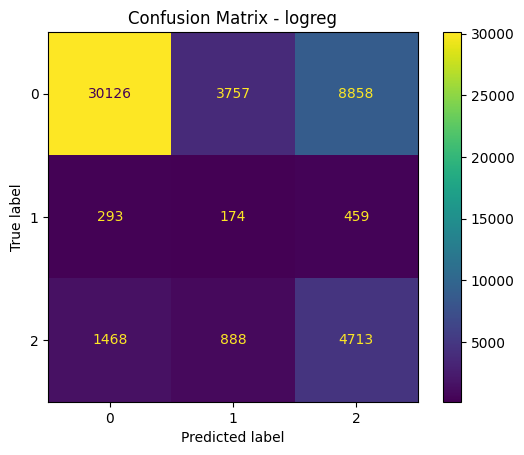


Classification Report:
              precision    recall  f1-score   support

           0     0.9448    0.7049    0.8074     42741
           1     0.0361    0.1879    0.0606       926
           2     0.3359    0.6667    0.4468      7069

    accuracy                         0.6901     50736
   macro avg     0.4389    0.5198    0.4382     50736
weighted avg     0.8434    0.6901    0.7435     50736



In [39]:
# %% [code] | Confusion matrix of the best model
from sklearn.utils.multiclass import unique_labels

y_pred_best = best_model.predict(X_test)
labels = np.sort(unique_labels(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, digits=4))

## 10. ROC curves (OVR)

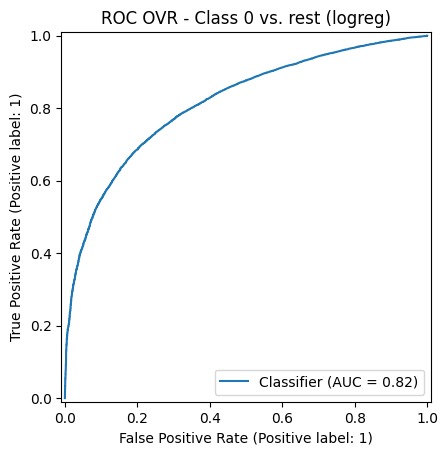

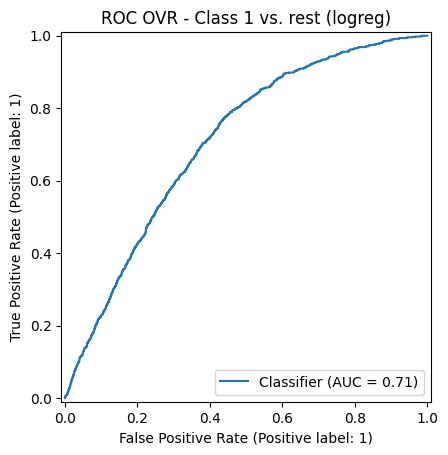

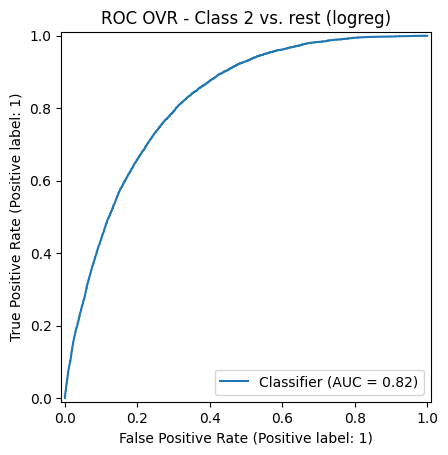

In [40]:
# %% [code] | ROC One-vs-Rest curves (if available)
try:
    y_score = best_model.predict_proba(X_test)
    n_classes = len(np.unique(y_test))
    # Plot para cada classe
    for i in range(n_classes):
        RocCurveDisplay.from_predictions((y_test == i).astype(int), y_score[:, i])
        plt.title(f"ROC OVR - Class {i} vs. rest ({best_name})")
        plt.show()
except Exception as e:
    print("ROC curves not available for this model:", e)

## 11. Feature importance

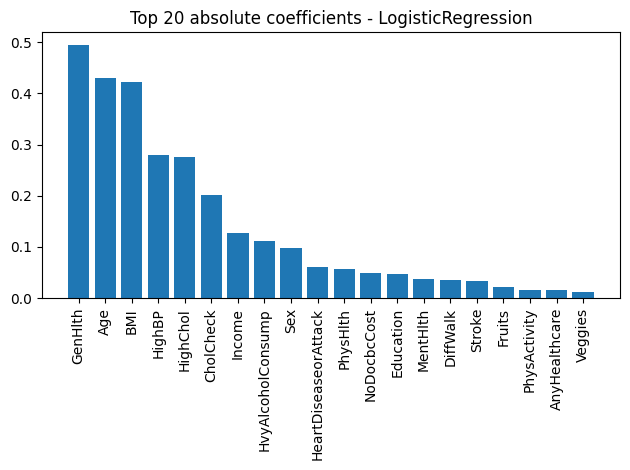

In [41]:
# %% [code] | Feature importance (when applicable)
feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(X_train.shape[1]).astype(str)

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    order = np.argsort(importances)[::-1][:20]
    plt.bar(range(len(order)), importances[order])
    plt.xticks(range(len(order)), feature_names[order], rotation=90)
    plt.title(f"Top 20 importances - {best_name}")
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, "named_steps") and "clf" in best_model.named_steps:
    clf = best_model.named_steps["clf"]
    if hasattr(clf, "coef_"):
        coefs = np.mean(np.abs(clf.coef_), axis=0)
        order = np.argsort(coefs)[::-1][:20]
        plt.bar(range(len(order)), coefs[order])
        plt.xticks(range(len(order)), feature_names[order], rotation=90)
        plt.title("Top 20 absolute coefficients - LogisticRegression")
        plt.tight_layout()
        plt.show()
    else:
        print("Model in the pipeline does not provide importances/coefficients.")
else:
    print("Feature importance not available for this model.")

## 12. Save best model

In [42]:
# %% [code] | Save model
MODEL_PATH = "./data/diabetes_best_model.pkl"
joblib.dump(best_model, MODEL_PATH)
print("Model saved to:", MODEL_PATH)

Model saved to: ./data/diabetes_best_model.pkl


## 13. Inference example

In [43]:
# %% [code] | Inference example
# Use the first row of the test set as an example
example = X_test.iloc[[0]].copy()
pred = best_model.predict(example)[0]
try:
    proba = best_model.predict_proba(example)[0]
except Exception:
    proba = None

print("Example prediction (class):", pred)
if proba is not None:
    print("Probabilities:", proba)
example

Example prediction (class): 0
Probabilities: [0.47099388 0.28496407 0.24404205]


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
167906,0.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,1.0,5.0,6.0,7.0
